<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_07_02_survival_analysis_random_survival_forest_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

#7.2 Random Survival Forest

Random Survival Forests are a powerful extension of Random Forests designed for survival analysis, which deals with time-to-event data. They are particularly useful in fields like medicine, engineering, and finance, where understanding the timing of events is crucial.


## Overview

A **Survival Forest**, often referred to as a **Random Survival Forest (RSF)**, is a machine learning model used for survival analysis. It extends the concept of Random Forests to handle time-to-event data, where the outcome of interest is the time until an event occurs (e.g., death, disease recurrence, or equipment failure). Survival Forests are particularly useful for modeling censored data, where the event of interest may not be observed for all subjects during the study period.


### Key Concepts

- **Survival Analysis**: Focuses on modeling the time until an event occurs. It accounts for **censoring**, where the event hasn't occurred for some subjects by the end of the observation period or they are lost to follow-up.
- **Random Forest**: A collection of decision trees that make predictions by averaging or voting across many trees, reducing overfitting and improving robustness.
- **Survival Forest**: Adapts Random Forests to predict survival outcomes, such as the probability of surviving past a certain time or the risk of an event occurring.


### How Survival Forests Work

Survival Forests combine the principles of Random Forests with survival analysis. Here’s a step-by-step explanation:

1. Understand the Data

Survival data consists of: - **Features**: $X = (X_1, X_2, \dots, X_p)$, a vector of predictors (e.g., age, blood pressure, treatment type).

- Event Time: $T$, the time to the event (or censoring time if the event doesn’t occur).

- Censoring Indicator: $\delta$, where $\delta = 1$ if the event is observed, and $\delta = 0$ if the observation is censored (e.g., patient lost to follow-up).

- Dataset: $\{(X_i, T_i, \delta_i)\}_{i=1}^n$, for $n$ observations.

- Estimate the survival function $S(t) = P(T > t)$, the probability of surviving past time $t$, or the cumulative hazard function $H(t) = \int_0^t h(u) \, du$, where $h(t)$ is the hazard rate.

2. Bootstrap Sampling

Survival Forests use the Random Forest principle of ensemble learning: - **Draw Bootstrap Samples**: For each of $B$ trees, randomly sample $n$ observations **with replacement** from the dataset. This creates a bootstrap sample $D_b = \{(X_i, T_i, \delta_i)\}_{i \in S_b}$, where $S_b$ is the set of indices for tree ( b ).

- Out-of-Bag (OOB) Data: Observations not included in the bootstrap sample for a tree are used for validation or error estimation.

3. Build Survival Trees

Each tree is constructed as follows:

-   Start at the Root Node:

   -   The root contains the bootstrap sample $D_b$.
    
   -   Select a random subset of features (e.g., $m = \sqrt{p}$ features, where $p$ is the total number of features).
    
-   Node Splitting:

  -   For each node, evaluate possible splits on the selected features.

  -   A split divides the node into two child nodes based on a feature $X_j$ and threshold $s$, e.g., $X \leq s$ (left child) and $X_j > s$ (right child).

    -   Choose the split that maximizes a survival-specific criterion, typically the **log-rank statistic**, which tests whether survival distributions differ between the two groups.

    -   Log-Rank Statistic:

    -   For a split at time $t$, let:

        -   $d_{i1}$: Number of events in the left child at time $t_i$.
        -   $n_{i1}$: Number of individuals at risk in the left child just before $t_i$.
        -   $d_i$: Total events at $t_i$ in the parent node.
        -   $n_i$: Total individuals at risk in the parent node.

    -   Expected events in the left child under the null hypothesis (no difference in survival):

$$ e_{i1} = \frac{n_{i1}}{n_i} \cdot d_i $$

  -   The log-rank statistic is:

$$ \chi^2 = \sum_{t_i} \frac{(d_{i1} - e_{i1})^2}{\text{Var}(d_{i1} - e_{i1})} $$

   where the variance is approximated as:

$$  \text{Var}(d_{i1} - e_{i1}) \approx \frac{n_{i1} \cdot (n_i - n_{i1}) \cdot d_i \cdot (n_i - d_i)}{n_i^2 \cdot (n_i - 1)} $$

   -   Choose the split (feature $X_j$, threshold $s$ that maximizes $\chi^2$.

    -   Grow the Tree:

    -   Recursively apply the splitting process to each child node until a stopping criterion is met (e.g., minimum node size, maximum depth, or insufficient events).

    -   Each leaf node contains a subset of observations.

    -   Leaf Node Estimation:

    -   For each leaf node, compute the **Nelson-Aalen estimator** for the cumulative hazard function (CHF) using the observations in that leaf:

$$ \hat{H}(t) = \sum_{t_i \leq t} \frac{d_i}{n_i} $$

        where:

   -   $t_i$: Distinct event times in the leaf.
   -   $d_i$: Number of events ($\delta_i = 1$) at time $t_i$.
   -   $n_i$: Number of individuals at risk just before $t_i$ (those with $T_i \geq t_i$).

    -   The survival function for the leaf is:

$$  \hat{S}(t) = e^{-\hat{H}(t)} $$

4. Aggregate Trees

For each observation $X$, the Survival Forest aggregates predictions across all $B$ trees: - Pass $X$ through each tree $b = 1, \dots, B$ to find the leaf node it belongs to.

- Retrieve the CHF $\hat{H}_b(t)$ from the leaf node of tree $b$.

- Compute the ensemble CHF by averaging:

$$ \hat{H}(t) = \frac{1}{B} \sum_{b=1}^B \hat{H}_b(t) $$

-   The ensemble survival function is:

$$ \hat{S}(t) = e^{-\hat{H}(t)} $$

Alternatively, some implementations average survival functions directly or use other aggregation methods, but the CHF is most common due to its stability.

5. Handling Censoring

Censoring is a key challenge in survival analysis. Survival Forests handle it by: - Including both censored ($\delta = 0$) and uncensored ($\delta = 1$) observations in the "at-risk" set $n_i$ until their event or censoring time.

- Only uncensored events contribute to $d_i$ in the Nelson-Aalen estimator.

- The log-rank statistic accounts for censoring by considering the expected number of events under the null hypothesis, adjusted for the at-risk population.

6. Prediction for New Data

For a new observation with features $X_{\text{new}}$:

-   Pass $X_{\text{new}}$ through each of the $B$ trees to find the corresponding leaf node.

-   Retrieve the CHF $\hat{H}_b(t)$ from each tree’s leaf.

-   Compute the ensemble CHF:

$$  \hat{H}(t) = \frac{1}{B} \sum_{b=1}^B \hat{H}_b(t) $$

-   Compute the survival function:

$$ \hat{S}(t) = e^{-\hat{H}(t)} $$

-   Optionally, compute the hazard function $h(t)$ by taking the derivative of $H(t)$, though this is less common in practice.

### Advantages of Random Survival Forest

-   `Non-parametric`: Does not assume a specific distribution for survival times (unlike traditional models like Cox regression).
-   `Handles Complex Relationships`: Captures non-linear relationships and interactions between features without needing explicit specification.
-   `Robust to Overfitting`: Randomization in tree construction (bootstrapping and feature subsampling) reduces overfitting.
-   `Feature Importance`: Can rank the importance of predictors in influencing survival outcomes.

### Limitations of Random Survival Forest

-   `Computationally Intensive`: Building many trees with survival-specific criteria can be slow for large datasets.
-   `Interpretability`: Like Random Forests, Survival Forests are less interpretable than simpler models like Cox regression.
-   `Tuning Required`: Parameters like the number of trees, depth, or feature subsampling need careful tuning for optimal performance.

### Applications of Random Survival Forest

-   `Medical Research`: Predicting patient survival or time to disease recurrence based on clinical and demographic features.
-   `Reliability Engineering`: Estimating time to failure for mechanical systems.
-   `Finance`: Modeling time to default on loans or other financial events.

## Setup and Installation


In [ ]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'scikit-survival', 'lifelines', 'statsmodels', 'pymer4', 'PyMC', 'polars']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

In [ ]:
# Install required packages if needed
# !pip install scikit-survival lifelines pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sksurv.tree import SurvivalTree
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")


Libraries imported successfully!


## Random Survival Forest from Scratch

In this section, we will implement a Random Survival Forest from scratch in Python. Below is a step-by-step implementation of the Random Survival Forest algorithm, including data preparation, tree construction, and prediction.

#### Data

The Melanoma data frame has data on 205 patients in Denmark with malignant Melanoma.
This data frame contains the following columns:

`time` - survival time in days, possibly censored.

`status` - 1 died from Melanoma, 2 alive, 3 dead from other causes.

`sex` - 1 = male, 0 = female.

`age` - age in years.

`year`- year of operation.

`thickness` - tumour thickness in mm.

`ulcer` - 1 = presence, 0 = absence.

In [ ]:
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/Melanoma.csv"
Melanoma = pd.read_csv(url)

In [ ]:
# Prepare data: Convert time to years, recode status (1 = event, 0 = censored)
Melanoma['time'] = Melanoma['time'] / 365  # Convert days to years
Melanoma['status'] = np.where(Melanoma['status'] == 1, 1, 0)  # 1 = died (Melanoma), 0 = alive or other cause
data = Melanoma[['time', 'status', 'age', 'sex', 'thickness', 'ulcer']].copy()  # Select relevant columns
# Remove any rows with NA in time, status, or predictors
data = data.dropna()

### Function to perform bootstrap sample

`bootstrap_sample()` function generates a bootstrap sample from the dataset, ensuring that the sample has at least one non-NA time and one event. If the sample is invalid (e.g., all times are NA or no events), it resamples until a valid sample is obtained.

In [ ]:
# Function to perform bootstrap sampling in Python
def bootstrap_sample(data, n):
    """
    Generate a bootstrap sample from the dataframe 'data' of size n.
    Ensures the sample has at least one non-NA time and one event.
    """
    import numpy as np
    import pandas as pd

    while True:
        sample_data = data.sample(n=n, replace=True)
        # Check for at least one non-NA time and at least one event
        if sample_data['time'].notna().any() and sample_data.shape[0] > 0 and sample_data['status'].fillna(0).sum() > 0:
            return sample_data

### Log-rank test for splitting

The log-rank test for splitting is a statistical method used to compare survival distributions between two groups, often in survival analysis or decision trees for survival data. It evaluates whether a split (based on a variable and threshold) creates two groups with significantly different survival times. The test is commonly used to select optimal splits in survival trees by maximizing the difference in survival curves.

`log_rank_test()` function calculates the log-rank test statistic for a given split in survival data.  In survival trees, this function evaluates potential splits by computing the log-rank statistic for each candidate split (variable and threshold). The split with the highest statistic is chosen, as it maximizes the survival difference between resulting groups.


In [ ]:
# Log-rank test for splitting in Python
def log_rank_test(time, status, split_var, split_point, is_categorical=False):
    """
    Compute the log-rank test statistic for a candidate split on survival data.

    Parameters:
        time: array-like, event/censoring times
        status: array-like, 1 if event, 0 if censored
        split_var: array-like, predictor for splitting
        split_point: scalar or value for split
        is_categorical: bool, if True, split is categorical

    Returns:
        stat: log-rank test statistic (float)
    """
    import numpy as np

    time = np.asarray(time)
    status = np.asarray(status)
    split_var = np.asarray(split_var)

    if is_categorical:
        group1 = split_var == split_point
    else:
        group1 = split_var <= split_point
    group2 = ~group1

    # Unique event times
    times = np.sort(np.unique(time[status == 1]))
    stat = 0.0

    for t in times:
        at_risk1 = np.sum(time[group1] >= t)
        at_risk2 = np.sum(time[group2] >= t)
        events1 = np.sum((time[group1] == t) & (status[group1] == 1))
        events2 = np.sum((time[group2] == t) & (status[group2] == 1))
        total_at_risk = at_risk1 + at_risk2
        if total_at_risk > 0:
            expected1 = at_risk1 * (events1 + events2) / total_at_risk
            if expected1 > 0:
                stat += ((events1 - expected1) ** 2) / expected1

    if np.isnan(stat):
        return float('-inf')
    else:
        return stat

### Build a single survival tree

The `build_survival_tree()` function constructs a single survival tree for survival data, recursively splitting data to maximize survival differences using the log-rank test. It predicts cumulative hazard functions (CHFs) at leaf nodes.

In [ ]:
import numpy as np
import pandas as pd

def build_survival_tree(
    data,
    max_depth=3,
    min_node_size=5,
    depth=0
):
    """
    Recursively builds a single survival tree for survival data.

    Parameters:
        data (pd.DataFrame): Survival data (must include columns: 'time', 'status', 'age', 'sex', 'thickness', 'ulcer')
        max_depth (int): Maximum depth of the tree
        min_node_size (int): Minimum samples per node
        depth (int): Current depth

    Returns:
        dict: Tree node (leaf or internal split)
    """
    def _make_leaf(data):
        observed_times = data.loc[data['status'] == 1, 'time'].dropna().values
        times = np.sort(np.unique(observed_times))
        if len(times) == 0:
            if data['time'].notna().any():
                max_time = data['time'].max()
            else:
                max_time = 10
            times = np.linspace(0, max_time, 2)
            chf = np.zeros_like(times)
        else:
            chf = []
            for t in times:
                d_i = ((data['time'] == t) & (data['status'] == 1)).sum()
                n_i = (data['time'] >= t).sum()
                chf.append(d_i / n_i if n_i > 0 else 0.0)
            chf = np.array(chf)
        cum_chf = np.cumsum(chf)
        return {
            "type": "leaf",
            "times": times,
            "chf": cum_chf
        }

    # Stopping criteria: max depth, small node, no events, or invalid data
    if (
        depth >= max_depth
        or len(data) < min_node_size
        or data['status'].sum() == 0
        or data['time'].isna().all()
    ):
        return _make_leaf(data)

    features = ["age", "sex", "thickness", "ulcer"]
    selected_features = np.random.choice(features, size=2, replace=False)

    best_stat = float('-inf')
    best_feature = None
    best_split = None

    for feature in selected_features:
        is_categorical = feature in ["sex", "ulcer"]
        feature_values = data[feature]
        if not is_categorical:
            split_points = feature_values.dropna().quantile(np.arange(0.1, 1.0, 0.1)).unique()
        else:
            split_points = feature_values.dropna().unique()
        if len(split_points) == 0:
            continue  # No valid split point
        for sp in split_points:
            stat = log_rank_test(
                data['time'].values,
                data['status'].values,
                feature_values.values,
                sp,
                is_categorical
            )
            if (stat is not None) and (not np.isnan(stat)) and (stat > best_stat):
                best_stat = stat
                best_feature = feature
                best_split = sp

    # If no valid split, return leaf
    if best_feature is None or pd.isna(best_split):
        return _make_leaf(data)

    # Split data
    if best_feature in ["sex", "ulcer"]:
        left_data = data[data[best_feature] == best_split]
        right_data = data[data[best_feature] != best_split]
    else:
        left_data = data[(data[best_feature] <= best_split) & (data[best_feature].notna())]
        right_data = data[(data[best_feature] > best_split) & (data[best_feature].notna())]

    # If child node(s) don't have enough data, return leaf
    if (len(left_data) < min_node_size) or (len(right_data) < min_node_size):
        return _make_leaf(data)

    # Recursively build left and right subtrees
    left_tree = build_survival_tree(left_data, max_depth, min_node_size, depth + 1)
    right_tree = build_survival_tree(right_data, max_depth, min_node_size, depth + 1)

    return {
        "type": "node",
        "feature": best_feature,
        "split": best_split,
        "left": left_tree,
        "right": right_tree
    }

### Predicting CHF for a single observation

The `predict_tree()` function predicts the cumulative hazard function (CHF) for a single observation by traversing a survival tree.

In [ ]:
# Predict CHF for a single observation through a tree (fixed)
def predict_tree(tree, x):
    if tree["type"] == "leaf":
        return {"times": tree["times"], "chf": tree["chf"]}
    feature_value = x.get(tree["feature"])
    if feature_value is None or tree["split"] is None or pd.isna(feature_value) or pd.isna(tree["split"]):
        # If feature value or split is NA, default to left child
        return predict_tree(tree["left"], x)
    if tree["feature"] in ["sex", "ulcer"]:
        if feature_value == tree["split"]:
            return predict_tree(tree["left"], x)
        else:
            return predict_tree(tree["right"], x)
    else:
        if feature_value <= tree["split"]:
            return predict_tree(tree["left"], x)
        else:
            return predict_tree(tree["right"], x)

### Build Random Survival Forest

The `rsf()` function builds a Random Survival Forest (RSF), an ensemble model for survival analysis. It constructs multiple survival trees using bootstrapped data to predict cumulative hazard functions (CHFs) and improve prediction robustness.

In [ ]:
# Build Random Survival Forest (Python version)
def rsf(data, n_trees=10, max_depth=3, min_node_size=5):
    trees = []
    for i in range(n_trees):
        boot_data = bootstrap_sample(data, len(data))
        tree = build_survival_tree(boot_data, max_depth, min_node_size)
        trees.append(tree)
    return trees

### Predict survival function for a new observation

The `predict_rsf()` function predicts the survival function for a new observation using a Random Survival Forest (RSF). It aggregates cumulative hazard function (CHF) predictions from multiple trees and converts them into a survival probability curve over specified times.

In [ ]:
# Predict survival function for a new observation (Python version)
import numpy as np

def approx_const(x, y, xout, yleft=0, yright=None):
    """
    Constant extrapolation for hazard step function.
    - x, y: known times and CHF values.
    - xout: times at which to interpolate.
    """
    y = np.asarray(y)
    x = np.asarray(x)
    xout = np.asarray(xout)
    res = np.full_like(xout, yleft, dtype=float)
    # Default yright for extrapolation
    if yright is None and len(y) > 0:
        yright = np.nanmax(y)
    for i, t in enumerate(xout):
        # If t < min(x), yleft
        if len(x) == 0 or t < x.min():
            res[i] = yleft
        # If t >= max(x), yright
        elif t >= x.max():
            res[i] = yright
        else:
            idx = np.searchsorted(x, t, side='right') - 1
            res[i] = y[idx] if idx >= 0 else yleft
    return res

def predict_rsf(trees, x, times):
    chf_values = np.zeros((len(trees), len(times)))
    for i, tree in enumerate(trees):
        pred = predict_tree(tree, x)
        if len(pred["times"]) == 0:
            chf_values[i, :] = 0
        else:
            chf_interp = approx_const(
                pred["times"],
                pred["chf"],
                times,
                yleft=0,
                yright=np.nanmax(pred["chf"]) if len(pred["chf"]) > 0 else 0
            )
            chf_values[i, :] = chf_interp
    mean_chf = np.nanmean(chf_values, axis=0)
    survival = np.exp(-mean_chf)
    return {"times": times, "survival": survival}

### Example Usage

    Time  Survival
0      0    1.0000
1      1    0.9697
2      2    0.9568
3      3    0.8976
4      4    0.8661
5      5    0.8395
6      6    0.7531
7      7    0.7364
8      8    0.6927
9      9    0.6426
10    10    0.6426


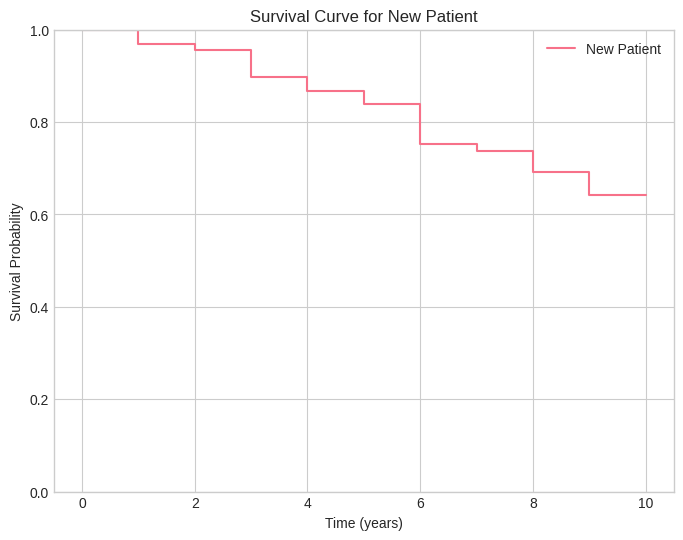

In [ ]:
# Example usage

np.random.seed(123)  # For reproducibility
forest = rsf(data, n_trees=10, max_depth=3, min_node_size=5)

# Predict survival for a new patient
new_patient = {'age': 50, 'sex': 1, 'thickness': 2.5, 'ulcer': 0}
# Make sure new_patient is in the right input shape for prediction function (e.g. a pandas DataFrame)
import pandas as pd
new_patient_df = pd.DataFrame([new_patient])

times = np.arange(0, 11, 1)  # Predict survival from 0 to 10 years
prediction = predict_rsf(forest, new_patient_df.iloc[0], times)

# Print survival probabilities
import pandas as pd
print(pd.DataFrame({'Time': times, 'Survival': np.round(prediction["survival"], 4)}))

# Plot survival curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.step(prediction["times"], prediction["survival"], where="post", label="New Patient")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.title("Survival Curve for New Patient")
plt.ylim(0, 1)
plt.legend()
plt.show()

  ## Random Survival Forest in Python

 Several Python libraries provide implementations of **Random Survival Forests (RSF)** for survival analysis, each with particular features and strengths.
 Below is a concise list of the main available Python packages for RSF as of 2024, based on their popularity and capabilities:

 1.  `scikit-survival`: The most widely used Python package for RSF. It offers robust implementations for survival analysis, including Random Survival Forests, Cox models, and more. Supports right-censored data, estimation of survival and hazard functions, and various model evaluation metrics.
     -   **Key Features**:
         -   Handles right-censored and interval-censored data
         -   Provides ensemble survival/hazard predictions
         -   Supports concordance index (C-index), Brier score, and time-dependent metrics
         -   Integration with scikit-learn pipelines
         -   Feature importance and model inspection tools
 2.  `lifelines`: This library provides a variety of tools for survival analysis, including machine learning estimators like Random Survival Forests (as of lifelines 0.26+), Kaplan-Meier estimators, and Cox models.
     -   **Key Features**:
         -   Interpretability tools for models and baseline estimation
         -   Supports right-censored survival data
         -   Integrated plotting for survival and hazard functions
         -   Fits into the PyData/scikit-learn workflow
 3.  `PySurvival`: A flexible survival analysis library offering RSF (plus Cox, parametric, and deep learning models) and evaluation tools.
     -   **Key Features**:
         -   Dynamic and time-varying survival prediction
         -   Easy model evaluation and simulation
         -   Handles left-, right-, and interval-censored data
         -   Feature importance and effect plots

 Each package differs in modeling approach, API, and additional features, so selection should be based on the requirements of your survival analysis task.

### Load Data

We'll use the Veteran dataset, which contains survival data from a lung cancer study.


In [ ]:
# Load the Veteran dataset
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/veteran_data.csv"
df = pd.read_csv(url)

# Select and prepare columns
df = df[['time', 'status', 'trt', 'celltype', 'karno', 'diagtime', 'age', 'prior']].copy()

# Encode factors
if df['celltype'].dtype == 'object':
    df['celltype'] = pd.Categorical(df['celltype']).codes + 1
df['trt'] = (df['trt'] == 1).astype(int) if df['trt'].max() > 1 else df['trt']
df['prior'] = (df['prior'] > 0).astype(int)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nSummary statistics:")
print(df.describe())


Dataset shape: (137, 8)

First few rows:
   time  status  trt  celltype  karno  diagtime  age  prior
0    72       1    1         4     60         7   69      0
1   411       1    1         4     70         5   64      1
2   228       1    1         4     60         3   38      0
3   126       1    1         4     60         9   63      1
4   118       1    1         4     70        11   65      1

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   time      137 non-null    int64
 1   status    137 non-null    int64
 2   trt       137 non-null    int64
 3   celltype  137 non-null    int8 
 4   karno     137 non-null    int64
 5   diagtime  137 non-null    int64
 6   age       137 non-null    int64
 7   prior     137 non-null    int64
dtypes: int64(7), int8(1)
memory usage: 7.8 KB
None

Summary statistics:
             time      status        

### Random Survival Forest using scikit-survival

The `scikit-survival` library provides a robust implementation of Random Survival Forests. Let's use it to fit a model and make predictions.


In [ ]:
# Prepare data in scikit-survival format
from sksurv.util import Surv

# Create structured array for survival outcomes
y = np.array([(bool(s), t) for s, t in zip(df['status'], df['time'])],
             dtype=[('status', bool), ('time', float)])

# Prepare features (exclude time and status)
X = df[['trt', 'celltype', 'karno', 'diagtime', 'age', 'prior']].values

print(f"Features shape: {X.shape}")
print(f"Outcomes shape: {y.shape}")
print(f"\nNumber of events: {y['status'].sum()}")
print(f"Number of censored: {(~y['status']).sum()}")


Features shape: (137, 6)
Outcomes shape: (137,)

Number of events: 128
Number of censored: 9


### Split Data into Training and Testing Sets


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y['status']
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nTraining events: {y_train['status'].sum()}")
print(f"Testing events: {y_test['status'].sum()}")


Training set: 95 samples
Testing set: 42 samples

Training events: 89
Testing events: 39


### Fit Random Survival Forest Model


In [ ]:
# Fit Random Survival Forest
rsf = RandomSurvivalForest(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

print("Fitting Random Survival Forest...")
rsf.fit(X_train, y_train)
print("Model fitted successfully!")


Fitting Random Survival Forest...
Model fitted successfully!


### Model Evaluation


In [ ]:
# Predict risk scores (higher = higher risk)
risk_scores_train = rsf.predict(X_train)
risk_scores_test = rsf.predict(X_test)

# Calculate C-index (concordance index)
c_index_train = concordance_index_censored(
    y_train['status'], y_train['time'], risk_scores_train
)[0]

c_index_test = concordance_index_censored(
    y_test['status'], y_test['time'], risk_scores_test
)[0]

print(f"Training C-index: {c_index_train:.4f}")
print(f"Testing C-index: {c_index_test:.4f}")
print(f"\nC-index interpretation:")
print(f"  - 0.5: Random predictions")
print(f"  - 1.0: Perfect predictions")
print(f"  - >0.7: Good discrimination")


Training C-index: 0.7732
Testing C-index: 0.7091

C-index interpretation:
  - 0.5: Random predictions
  - 1.0: Perfect predictions
  - >0.7: Good discrimination


### Variable Importance


Calculating variable importance using permutation method...
This may take a few minutes...

Processing trt... Importance: -0.0211
Processing celltype... Importance: 0.0335
Processing karno... Importance: 0.1308
Processing diagtime... Importance: -0.0168
Processing age... Importance: -0.0145
Processing prior... Importance: 0.0012

Variable Importance (Permutation-based):
 Feature  Importance      Std
   karno    0.130788 0.060423
celltype    0.033455 0.015093
   prior    0.001212 0.004787
     age   -0.014545 0.012839
diagtime   -0.016848 0.011707
     trt   -0.021091 0.009790


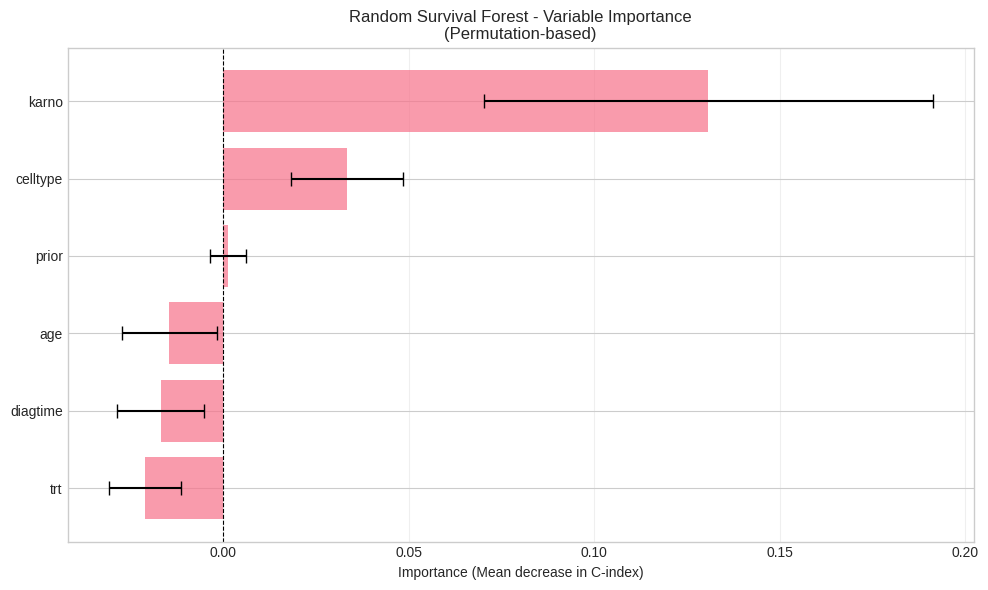


Note: Higher importance values indicate features that have a greater
impact on model performance when permuted (shuffled).
Baseline C-index: 0.7091


In [ ]:
# Calculate Variable Importance using Permutation Importance
# Note: scikit-survival's RandomSurvivalForest doesn't implement feature_importances_
# So we'll calculate it manually using permutation importance

print("Calculating variable importance using permutation method...")
print("This may take a few minutes...\n")

# Get feature names
feature_names = ['trt', 'celltype', 'karno', 'diagtime', 'age', 'prior']

# Baseline C-index on test set
baseline_risk = rsf.predict(X_test)
baseline_c_index = concordance_index_censored(
    y_test['status'], y_test['time'], baseline_risk
)[0]

# Calculate permutation importance for each feature
n_repeats = 10
importances = []
importances_std = []

for i, feature_name in enumerate(feature_names):
    print(f"Processing {feature_name}...", end=' ')
    feature_importance = []

    for repeat in range(n_repeats):
        # Create a copy of test data
        X_test_permuted = X_test.copy()

        # Permute (shuffle) the feature
        np.random.seed(42 + repeat)
        permuted_values = np.random.permutation(X_test_permuted[:, i])
        X_test_permuted[:, i] = permuted_values

        # Predict with permuted feature
        permuted_risk = rsf.predict(X_test_permuted)
        permuted_c_index = concordance_index_censored(
            y_test['status'], y_test['time'], permuted_risk
        )[0]

        # Importance is the decrease in C-index
        feature_importance.append(baseline_c_index - permuted_c_index)

    importances.append(np.mean(feature_importance))
    importances_std.append(np.std(feature_importance))
    print(f"Importance: {np.mean(feature_importance):.4f}")

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Std': importances_std
}).sort_values('Importance', ascending=False)

print("\n" + "="*50)
print("Variable Importance (Permutation-based):")
print("="*50)
print(importance_df.to_string(index=False))

# Plot variable importance
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'],
         xerr=importance_df['Std'], capsize=5, alpha=0.7)
plt.xlabel('Importance (Mean decrease in C-index)')
plt.title('Random Survival Forest - Variable Importance\n(Permutation-based)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

print("\nNote: Higher importance values indicate features that have a greater")
print("impact on model performance when permuted (shuffled).")
print(f"Baseline C-index: {baseline_c_index:.4f}")


### Predict Survival Functions


In [ ]:
# Predict survival functions for test set
survival_functions = rsf.predict_survival_function(X_test, return_array=True)

# Get event times from the survival function predictions
# When return_array=False, the survival function has a .x attribute with time points
# Get times from one sample prediction
sample_surv = rsf.predict_survival_function(X_test[0:1], return_array=False)[0]
event_times = sample_surv.x  # Extract time points from the survival function

print(f"Number of unique event times: {len(event_times)}")
print(f"Time range: {event_times.min():.1f} to {event_times.max():.1f} days")
print(f"\nSurvival functions shape: {survival_functions.shape}")
print(f"  - Rows: {survival_functions.shape[0]} (number of test samples)")
print(f"  - Columns: {survival_functions.shape[1]} (number of time points)")


Number of unique event times: 76
Time range: 1.0 to 999.0 days

Survival functions shape: (42, 76)
  - Rows: 42 (number of test samples)
  - Columns: 76 (number of time points)


### Visualize Survival Curves


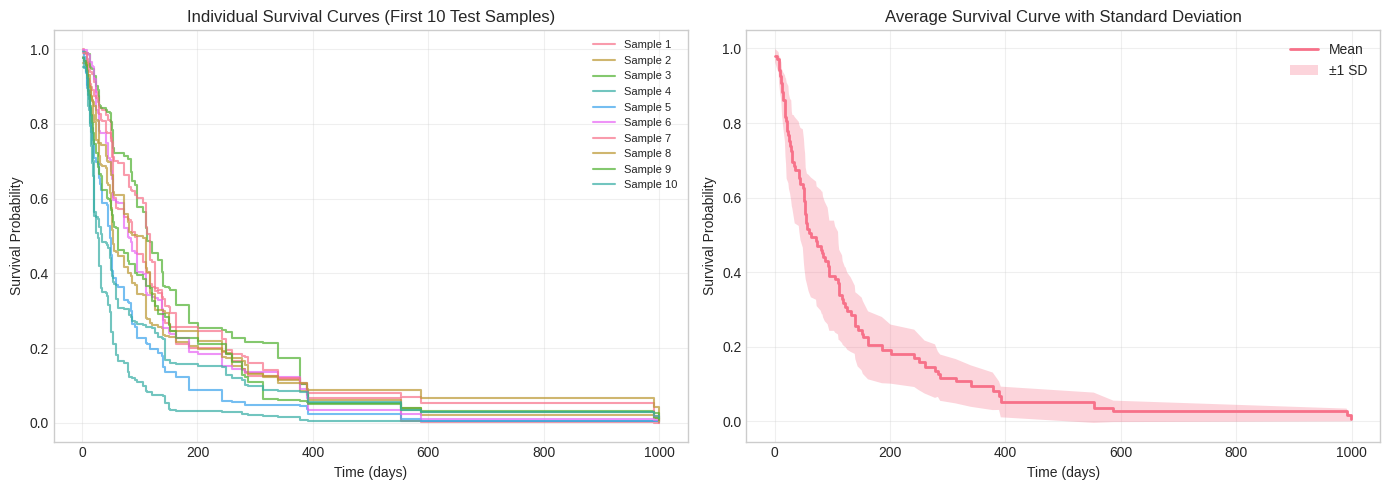

In [ ]:
# Plot survival curves for a few test samples
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Individual survival curves for first 10 test samples
ax1 = axes[0]
for i in range(min(10, len(survival_functions))):
    ax1.step(event_times, survival_functions[i], where='post', alpha=0.7, linewidth=1.5)
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Survival Probability')
ax1.set_title('Individual Survival Curves (First 10 Test Samples)')
ax1.grid(True, alpha=0.3)
ax1.legend([f'Sample {i+1}' for i in range(min(10, len(survival_functions)))],
           loc='upper right', fontsize=8)

# Plot 2: Average survival curve
ax2 = axes[1]
mean_survival = survival_functions.mean(axis=0)
std_survival = survival_functions.std(axis=0)
ax2.step(event_times, mean_survival, where='post', linewidth=2, label='Mean')
ax2.fill_between(event_times,
                 mean_survival - std_survival,
                 mean_survival + std_survival,
                 alpha=0.3, label='±1 SD')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Survival Probability')
ax2.set_title('Average Survival Curve with Standard Deviation')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()


### Compare with Kaplan-Meier Estimator


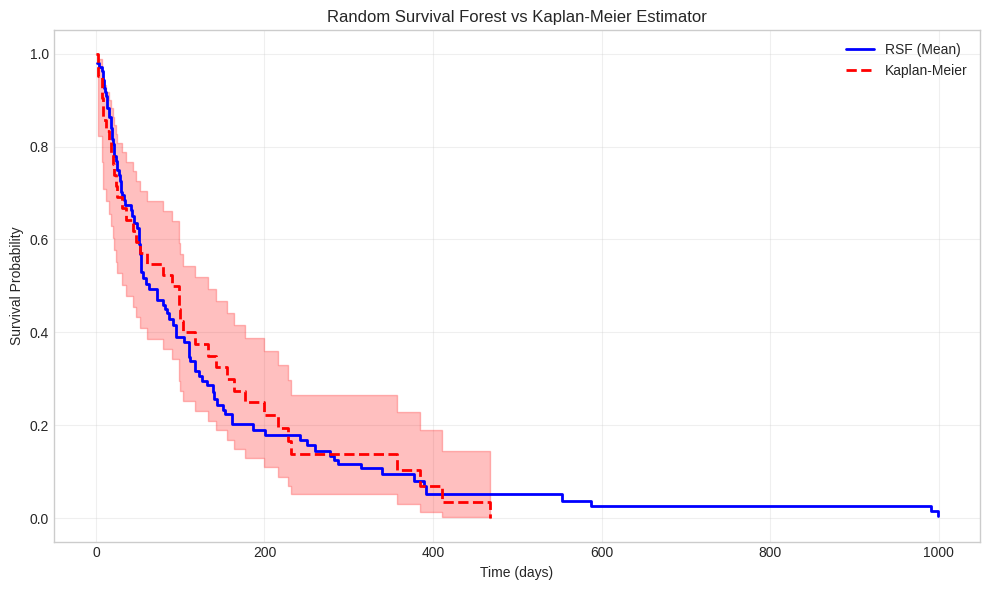

In [ ]:
# Fit Kaplan-Meier on test set for comparison
kmf = KaplanMeierFitter()
kmf.fit(y_test['time'], y_test['status'])

# Plot comparison
plt.figure(figsize=(8, 6))
plt.step(event_times, mean_survival, where='post', linewidth=2,
         label='RSF (Mean)', color='blue')
kmf.plot_survival_function(ax=plt.gca(), label='Kaplan-Meier',
                          color='red', linestyle='--', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.title('Random Survival Forest vs Kaplan-Meier Estimator')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Predictions for New Patients


In [ ]:
# Example: Predict for a new patient
new_patient = np.array([[1, 1, 60, 7, 69, 0]])  # [trt, celltype, karno, diagtime, age, prior]

# Predict risk score
risk_score = rsf.predict(new_patient)
print(f"Predicted risk score: {risk_score[0]:.4f}")
print("(Higher values indicate higher risk)")

# Predict survival function
survival_func = rsf.predict_survival_function(new_patient, return_array=True)[0]

# Predict survival probability at specific time points
time_points = [30, 60, 90, 180, 365]
survival_probs = rsf.predict_survival_function(new_patient, return_array=False)[0]

print(f"\nSurvival probabilities at specific time points:")
for t in time_points:
    # Find closest time point
    idx = np.argmin(np.abs(event_times - t))
    prob = survival_func[idx]
    print(f"  {t} days: {prob:.4f} ({prob*100:.2f}%)")


Predicted risk score: 73.8869
(Higher values indicate higher risk)

Survival probabilities at specific time points:
  30 days: 0.7601 (76.01%)
  60 days: 0.5619 (56.19%)
  90 days: 0.3777 (37.77%)
  180 days: 0.1235 (12.35%)
  365 days: 0.0317 (3.17%)


## Summary

Random Survival Forests provide a powerful, non-parametric approach to survival analysis that:

1. **Handles Censored Data**: Properly accounts for right-censored observations
2. **Non-parametric**: Makes no assumptions about the underlying survival distribution
3. **Feature Interactions**: Automatically captures complex interactions between features
4. **Variable Importance**: Provides insights into which features are most predictive
5. **Robust Predictions**: Ensemble approach reduces overfitting

### Advantages
- No assumptions about baseline hazard or proportional hazards
- Handles mixed data types and interactions naturally
- Robust to outliers
- Provides variable importance measures

### Limitations
- Computationally intensive for large datasets
- Less interpretable than simpler models like Cox regression
- Requires careful tuning of hyperparameters
- May require larger sample sizes for stable estimates

### Applications
- Medical Research: Predicting patient survival or time to disease recurrence
- Reliability Engineering: Estimating time to failure for mechanical systems
- Finance: Modeling time to default on loans or other financial events


## Resources

Here are some helpful resources related to Random Survival Forests in Python:

- **scikit-survival Documentation**:  
  https://scikit-survival.readthedocs.io/en/stable/user_guide/random_survival_forest.html

- **lifelines Library (alternative survival analysis library with Random Survival Forest)**:  
  https://lifelines.readthedocs.io/en/latest/Survival%20Forests.html

- **Original Random Survival Forest Paper by Ishwaran et al. (2008)**:  
  https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1541-0420.2007.00881.x

- **Introduction to Random Survival Forests (Statistical Methods in Medical Research)**:  
  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2943087/

- **scikit-survival Example Notebooks**:  
  https://github.com/sebp/scikit-survival/tree/main/examples

- **Survival Analysis with scikit-survival [Comprehensive Tutorial]**:  
  https://scikit-survival.readthedocs.io/en/stable/user_guide.html

- **YouTube: Survival Analysis in Python (Random Survival Forest)**:  
  https://www.youtube.com/watch?v=PTlysRJl66U
